In [1]:
import tensorflow as tf
import time
from datetime import timedelta
import numpy as np
ks=tf.keras
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Data

In [2]:
from kgcnn.graph.base import GraphDict
from kgcnn.data.base import MemoryGraphList, MemoryGraphDataset
from kgcnn.data.qm import QMDataset
from kgcnn.training.scheduler import LinearLearningRateScheduler

In [3]:
dataset = QMDataset(data_directory="ExampleQM", file_name="ThiolDisulfidExchange.csv", dataset_name="ThiolDisulfidExchange")

In [4]:
dataset.prepare_data(overwrite=True, make_sdf = True);

INFO:kgcnn.data.ThiolDisulfidExchange:Converting xyz to mol information.


In [7]:
dataset.read_in_memory(label_column_name="energy", additional_callbacks = {'total_charge': lambda mg, dd: dd['total_charge']});

INFO:kgcnn.data.ThiolDisulfidExchange:Reading structures from SDF file.
INFO:kgcnn.data.ThiolDisulfidExchange: ... process molecules 0 from 5112
INFO:kgcnn.data.ThiolDisulfidExchange: ... process molecules 5000 from 5112


In [8]:
dataset.map_list(method="set_range", max_distance=5.0);
dataset.map_list(method="set_angle");

In [9]:
dataset.save();

INFO:kgcnn.data.ThiolDisulfidExchange:Pickle dataset...


In [13]:
dataset = MemoryGraphDataset(data_directory="ExampleQM", dataset_name="ThiolDisulfidExchange")
dataset.load();
print(dataset[0].keys())

INFO:kgcnn.data.ThiolDisulfidExchange:Load pickled dataset...


dict_keys(['node_symbol', 'node_number', 'node_coordinates', 'edge_indices', 'edge_number', 'total_charge', 'graph_labels', 'range_indices', 'range_attributes', 'angle_indices', 'angle_indices_nodes', 'angle_attributes'])
-1.0


## 2. Model

In [14]:
from kgcnn.literature.HDNNP4th import make_model_behler as make_model

In [15]:
model_config = {
    "name": "HDNNP4th",
    "inputs": [{"shape": (None,), "name": "node_number", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "node_coordinates", "dtype": "float32", "ragged": True},
               {"shape": (None, 2), "name": "edge_indices", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "angle_indices_nodes", "dtype": "int64", "ragged": True},
               {"shape": (1,), "name": "total_charge", "dtype": "float32", "ragged": False}],
    "g2_kwargs": {"eta": [0.0, 0.3], "rs": [0.0, 3.0], "rc": 10.0, "elements": [1, 6, 16]},
    "g4_kwargs": {"eta": [0.0, 0.3], "lamda": [-1.0, 1.0], "rc": 6.0,
                  "zeta": [1.0, 8.0], "elements": [1, 6, 16], "multiplicity": 2.0},
    "normalize_kwargs": {},
    "mlp_charge_kwargs": {"units": [64, 64, 1],
                          "num_relations": 96,
                          "activation": ["swish", "swish", "linear"]},
    "mlp_local_kwargs": {"units": [64, 64, 1],
                         "num_relations": 96,
                         "activation": ["swish", "swish", "linear"]},
    "cent_kwargs": {},
    "electrostatic_kwargs": {"name": "electrostatic_layer"},
    "node_pooling_args": {"pooling_method": "sum"},
    "verbose": 10,
    "output_embedding": "graph", "output_to_tensor": True,
    "use_output_mlp": False,
    "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                   "activation": ["swish", "linear"]}
}

In [16]:
model = make_model(**model_config);

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'HDNNP4th', 'inputs': [{'shape': (None,), 'name': 'node_number', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'node_coordinates', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'angle_indices_nodes', 'dtype': 'int64', 'ragged': True}, {'shape': (1,), 'name': 'total_charge', 'dtype': 'float32', 'ragged': False}], 'g2_kwargs': {'eta': [0.0, 0.3], 'rs': [0.0, 3.0], 'rc': 10.0, 'elements': [1, 6, 16]}, 'g4_kwargs': {'eta': [0.0, 0.3], 'lamda': [-1.0, 1.0], 'rc': 6.0, 'zeta': [1.0, 8.0], 'elements': [1, 6, 16], 'multiplicity': 2.0}, 'normalize_kwargs': {}, 'mlp_charge_kwargs': {'units': [64, 64, 1], 'num_relations': 96, 'activation': ['swish', 'swish', 'linear']}, 'mlp_local_kwargs': {'units': [64, 64, 1], 'num_relations': 96, 'activation': ['swish', 'swish', 'linear']}, 'cent_kwargs': {}, 'electros

In [25]:
elemental_mapping = [1,6,16]

# Radial parameters
cutoff_rad = 10
Rs_array   = [0.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
eta_array  = [0.0, 0.03, 0.08, 0.16, 0.3, 0.5]

# Angular parameters
cutoff_ang    = 6
lambd_array   = [-1, 1]
zeta_array    = [1, 2, 4, 8, 16]
eta_ang_array = eta_array

In [26]:
from kgcnn.layers.modules import LazyConcatenate
from kgcnn.layers.conv.acsf_conv import ACSFG2, ACSFG4

__model_version__ = "2023.01.09"

def make_model_rep( inputs: list = None,
                    name: str = None,
                    verbose: int = None,
                    g2_kwargs: dict = None,
                    g4_kwargs: dict = None,
                    ):
    # Make input
    node_input = ks.layers.Input(**inputs[0])
    xyz_input = ks.layers.Input(**inputs[1])
    edge_index_input = ks.layers.Input(**inputs[2])
    angle_index_input = ks.layers.Input(**inputs[3])

    # ACSF representation.
    rep_g2 = ACSFG2(**ACSFG2.make_param_table(**g2_kwargs))([node_input, xyz_input, edge_index_input])
    rep_g4 = ACSFG4(**ACSFG4.make_param_table(**g4_kwargs))([node_input, xyz_input, angle_index_input])
    rep = LazyConcatenate()([rep_g2, rep_g4])
    
    model = ks.models.Model(
        inputs=[node_input, xyz_input, edge_index_input, angle_index_input], outputs=rep, name=name)
    model.__kgcnn_model_version__ = __model_version__
    return model

rep_model_configs = {
    "name": "HDNNP2nd",
    "inputs": [{"shape": (None,), "name": "node_number", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "node_coordinates", "dtype": "float32", "ragged": True},
               {"shape": (None, 2), "name": "edge_indices", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "angle_indices_nodes", "dtype": "int64", "ragged": True}],
    "g2_kwargs": {"eta": eta_array, "rs": Rs_array, "rc": cutoff_rad, "elements": elemental_mapping},
    "g4_kwargs": {"eta": eta_ang_array, "zeta": zeta_array, "lamda": lambd_array, "rc": cutoff_ang, "elements": elemental_mapping}
}
# rep_model = make_model_rep(**rep_model_configs)
# rep = rep_model.predict(dataset.tensor(rep_model_configs["inputs"]))
# for i in range(len(dataset)):
#    dataset[i].set("rep", rep[i])

160/160 [==============================] - 4s 17ms/step


In [38]:
from kgcnn.layers.mlp import RelationalMLP
from kgcnn.layers.pooling import PoolingNodes
from kgcnn.layers.mlp import GraphMLP, MLP
from kgcnn.layers.casting import ChangeTensorType
from kgcnn.layers.conv.hdnnp_conv import CENTCharge, ElectrostaticEnergyCharge
from kgcnn.layers.mlp import RelationalMLP
from kgcnn.layers.norm import GraphBatchNormalization

def make_model_learn(inputs: list = None,
                      node_pooling_args: dict = None,
                      name: str = None,
                      verbose: int = None,
                      normalize_kwargs: dict = None,
                      mlp_charge_kwargs: dict = None,
                      mlp_local_kwargs: dict = None,
                      cent_kwargs: dict = None,
                      electrostatic_kwargs: dict = None,
                      output_embedding: str = None,
                      use_output_mlp: bool = None,
                      output_to_tensor: bool = None,
                      output_mlp: dict = None
                      ):
    r"""Make 4th generation `HDNNP <https://www.nature.com/articles/s41467-020-20427-2>`_ graph network via
    functional API.

    Default parameters can be found in :obj:`kgcnn.literature.HDNNP4th.model_default_behler` .

    Inputs:
        list: `[node_number, node_coordinates, edge_indices, angle_indices_nodes, total_charge]`

            - node_number (tf.RaggedTensor): Atomic number of shape `(batch, None)` .
            - node_coordinates (tf.RaggedTensor): Node (atomic) coordinates of shape `(batch, None, 3)` .
            - edge_indices (tf.RaggedTensor): Index list for edges of shape `(batch, None, 2)` .
            - angle_indices_nodes (tf.RaggedTensor): Index list for angles of shape `(batch, None, 3)` .
            - total_charge (tf.Tensor): Total charge of each molecule of shape `(batch, 1)` .

    Outputs:
        tf.Tensor: Graph embeddings of shape `(batch, L)` if :obj:`output_embedding="graph"`.

    Args:
        inputs (list): List of dictionaries unpacked in :obj:`tf.keras.layers.Input`. Order must match model definition.
        node_pooling_args (dict): Dictionary of layer arguments unpacked in :obj:`PoolingNodes` layers.
        verbose (int): Level of verbosity.
        name (str): Name of the model.
        normalize_kwargs (dict): Dictionary of layer arguments unpacked in :obj:`GraphBatchNormalization` layer.
        mlp_charge_kwargs (dict): Dictionary of layer arguments unpacked in :obj:`RelationalMLP` layer.
        mlp_local_kwargs (dict): Dictionary of layer arguments unpacked in :obj:`RelationalMLP` layer.
        electrostatic_kwargs (dict): Dictionary of layer arguments unpacked in :obj:`ElectrostaticEnergyCharge` layer.
        cent_kwargs (dict): Dictionary of layer arguments unpacked in :obj:`CENTCharge` layer.
        output_embedding (str): Main embedding task for graph network. Either "node", "edge" or "graph".
        use_output_mlp (bool): Whether to use the final output MLP. Possibility to skip final MLP.
        output_to_tensor (bool): Whether to cast model output to :obj:`tf.Tensor`.
        output_mlp (dict): Dictionary of layer arguments unpacked in the final classification :obj:`MLP` layer block.
            Defines number of model outputs and activation.

    Returns:
        :obj:`tf.keras.models.Model`

    """
    # Make input
    node_input = ks.layers.Input(**inputs[0])
    xyz_input = ks.layers.Input(**inputs[1])
    edge_index_input = ks.layers.Input(**inputs[2])
    angle_index_input = ks.layers.Input(**inputs[3])
    total_charge_input = ks.layers.Input(**inputs[4])
    rep_input  = ks.layers.Input(**inputs[5])


    # Normalization
    if normalize_kwargs:
        rep_input = GraphBatchNormalization(**normalize_kwargs)(rep_input)

    # learnable NN.
    chi = RelationalMLP(**mlp_charge_kwargs)([rep_input, node_input])
    q_local = CENTCharge(**cent_kwargs)([node_input, chi, xyz_input, total_charge_input])
    eng_elec = ElectrostaticEnergyCharge(**electrostatic_kwargs)([node_input, q_local, xyz_input, edge_index_input])

    rep_charge = LazyConcatenate()([rep_input, q_local])
    local_node_energy = RelationalMLP(**mlp_local_kwargs)([rep_charge, node_input])
    eng_short = PoolingNodes(**node_pooling_args)(local_node_energy)

    out = ks.layers.Add()([eng_short, eng_elec])

    # Output embedding choice
    if output_embedding == 'graph':
        if use_output_mlp:
            out = MLP(**output_mlp)(out)
    else:
        raise ValueError("Unsupported output embedding for mode `HDNNP4th`")

    model = ks.models.Model(
        inputs=[node_input, xyz_input, edge_index_input, angle_index_input, total_charge_input, rep_input], outputs=out, name=name)

    model.__kgcnn_model_version__ = __model_version__
    return model

model_learn_config = {
    "name": "HDNNP4th",
    "inputs": [{"shape": (None,), "name": "node_number", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "node_coordinates", "dtype": "float32", "ragged": True},
               {"shape": (None, 2), "name": "edge_indices", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "angle_indices_nodes", "dtype": "int64", "ragged": True},
               {"shape": (1,), "name": "total_charge", "dtype": "float32", "ragged": False},
               {"shape": (None, 486), "name": "rep", "dtype": "float32", "ragged": True}],
    "normalize_kwargs": {},
    "mlp_charge_kwargs": {"units": [64, 64, 1],
                          "num_relations": 96,
                          "activation": ["swish", "swish", "linear"]},
    "mlp_local_kwargs": {"units": [64, 64, 1],
                         "num_relations": 96,
                         "activation": ["swish", "swish", "linear"]},
    "cent_kwargs": {},
    "electrostatic_kwargs": {"name": "electrostatic_layer"},
    "node_pooling_args": {"pooling_method": "sum"},
    "verbose": 10,
    "output_embedding": "graph", "output_to_tensor": True,
    "use_output_mlp": False,
    "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                   "activation": ["swish", "linear"]}
}

In [30]:
inputs = dataset.tensor(model_learn_config["inputs"])
print(len(inputs))
for i in range(len(inputs)):
    print(inputs[i].shape)

6
(5112, None)
(5112, None, 3)
(5112, None, 2)
(5112, None, 3)
(5112,)
(5112, None, 486)


In [31]:
from kgcnn.scaler.mol import ExtensiveMolecularScaler
scaler = ExtensiveMolecularScaler(standardize_scale=False)
labels = np.expand_dims(np.array(dataset.get("graph_labels"))/0.0367493, axis=-1)

In [32]:
labels = scaler.fit_transform(labels, atomic_number=dataset.get("node_number"))
labels.shape

(5112, 1)

In [33]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [45]:
hists = []
for train_index, test_index in kf.split(X=labels):
    model = make_model_learn(**model_learn_config)
    model.compile(loss="mean_squared_error", metrics=["mean_absolute_error"], 
                  optimizer=ks.optimizers.Adam(learning_rate=5e-5))
    
    x_train, y_train = dataset[train_index].tensor(model_learn_config["inputs"]), labels[train_index]
    x_test, y_test = dataset[test_index].tensor(model_learn_config["inputs"]), labels[test_index]
    
    start = time.process_time()
    hist = model.fit(
        x_train, y_train,
        callbacks=[LinearLearningRateScheduler(
            learning_rate_start=1e-3, learning_rate_stop=1e-8, epo_min=0, epo=300)
        ],
        validation_data=(x_test, y_test),
        epochs=300,
        verbose=0
    )
    stop = time.process_time()
    print("Print Time for training: ", str(timedelta(seconds=stop - start)))
    hists.append(hist)

model.summary()

c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_57/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_57/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_57/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_57/Reshape_3:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrosta

Print Time for training:  0:43:15.656250


c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_59/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_59/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_59/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_59/Reshape_3:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrosta

Print Time for training:  0:42:14.609375


c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_61/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_61/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_61/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_61/Reshape_3:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrosta

Print Time for training:  0:43:32.718750


c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_63/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_63/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_63/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_63/Reshape_3:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrosta

Print Time for training:  1:05:01.468750


c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_65/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_65/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_65/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_65/Reshape_3:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrosta

Print Time for training:  1:09:38.843750
Model: "HDNNP4th"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rep (InputLayer)               [(None, None, 486)]  0           []                               
                                                                                                  
 node_number (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 relational_mlp_37 (RelationalM  (None, None, 1)     3385473     ['rep[0][0]',                    
 LP)                                                              'node_number[0][0]']            
                                                                                                  
 node_coordinates (InputLayer)  [(None, None, 3)] 

In [46]:
true_y = scaler.inverse_transform(labels[test_index], atomic_number=dataset[test_index].get("node_number"))
start = time.process_time()
predicted_y = scaler.inverse_transform(model.predict(x_test), atomic_number=dataset[test_index].get("node_number"))
stop = time.process_time()
print("Print Time for training: ", str(timedelta(seconds=stop - start)))

32/32 [==============================] - 5s 35ms/step
Print Time for training:  0:00:06.375000


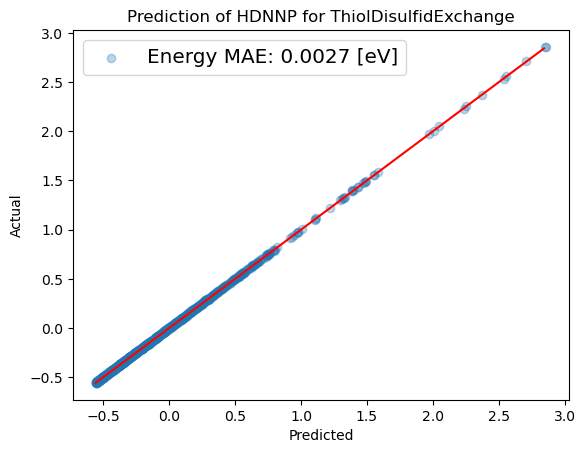

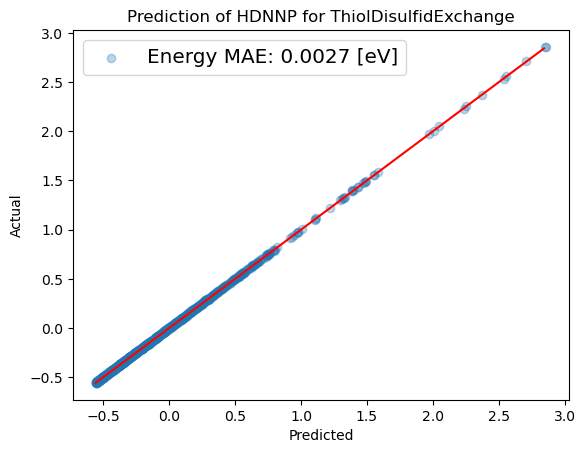

In [47]:
from kgcnn.utils.plots import plot_predict_true
plot_predict_true(predicted_y, true_y,
                  filepath="ExampleQM/", data_unit="eV",
                  model_name="HDNNP", dataset_name="ThiolDisulfidExchange", target_names="Energy",
                  file_name=f"predict.png")

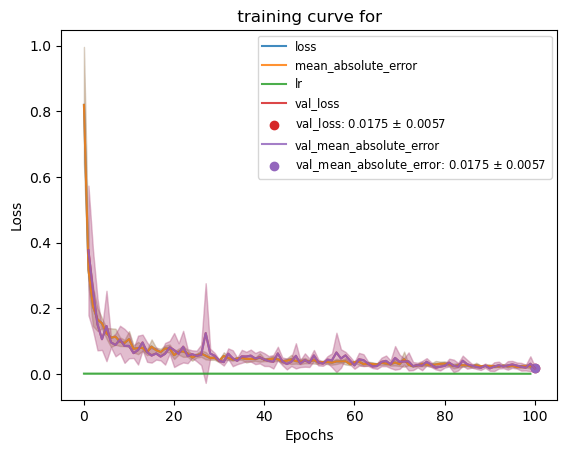

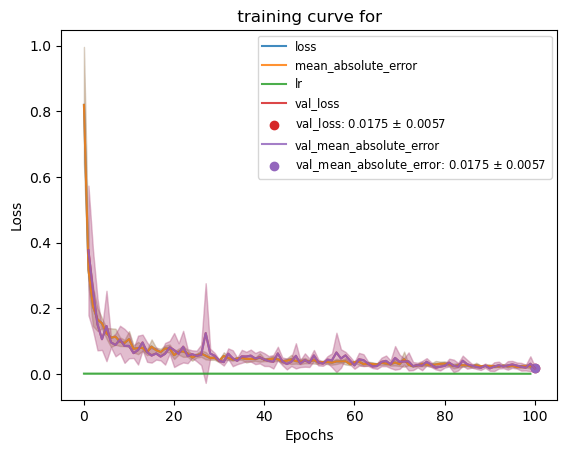

In [43]:
from kgcnn.utils.plots import plot_train_test_loss
plot_train_test_loss(hists)